## Engagement Level Test

### Business Problem

A social network company decided to add a feature called: Recommended Friends, i.e. they suggest people you may know.

A data scientist has built a model to suggest 5 people to each user. These potential friends will be shown on the user newsfeed. At ﬁrst, the model is tested just on a random subset of users to see how it performs compared to the newsfeed without the new feature.

The test has been running for some time and your boss asks you to check the results. You are asked to check, for each user, the number of pages visited during their ﬁrst session since the test started. If this number increased, the test is a success.

#### Load Dataset

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
user = pd.read_csv("user_table.csv",parse_dates = ["signup_date"])
user.head()

,user_id,signup_date
0,34,2015-01-01
1,59,2015-01-01
2,178,2015-01-01
3,285,2015-01-01
4,383,2015-01-01


In [3]:
test = pd.read_csv("test_table.csv",parse_dates = ['date'])
test.head()

,user_id,date,browser,test,pages_visited
0,600597,2015-08-13,IE,0,2
1,4410028,2015-08-26,Chrome,1,5
2,6004777,2015-08-17,Chrome,0,8
3,5990330,2015-08-27,Safari,0,8
4,3622310,2015-08-07,Firefox,0,1


In [4]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      100000 non-null  int64         
 1   signup_date  100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.5 MB


In [5]:
len(user.user_id.unique())

100000

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        100000 non-null  int64         
 1   date           100000 non-null  datetime64[ns]
 2   browser        100000 non-null  object        
 3   test           100000 non-null  int64         
 4   pages_visited  100000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 3.8+ MB


In [7]:
data = pd.merge(test,user,on="user_id",how = "left")

In [9]:
data.head()

,user_id,date,browser,test,pages_visited,signup_date
0,600597,2015-08-13,IE,0,2,2015-01-19
1,4410028,2015-08-26,Chrome,1,5,2015-05-11
2,6004777,2015-08-17,Chrome,0,8,2015-06-26
3,5990330,2015-08-27,Safari,0,8,2015-06-25
4,3622310,2015-08-07,Firefox,0,1,2015-04-17


In [8]:
data.isnull().sum()

user_id          0
date             0
browser          0
test             0
pages_visited    0
signup_date      0
dtype: int64

### Feature Engineering

Add a new feature called new_user based on signup_date.

In [29]:
data['sign_days'] = (data.date - data.signup_date).dt.days
data['new_user'] = (data.sign_days == 0).astype(int)
data.head()

,user_id,date,browser,test,pages_visited,signup_date,sign_days,new_user
0,600597,2015-08-13,IE,0,2,2015-01-19,206,0
1,4410028,2015-08-26,Chrome,1,5,2015-05-11,107,0
2,6004777,2015-08-17,Chrome,0,8,2015-06-26,52,0
3,5990330,2015-08-27,Safari,0,8,2015-06-25,63,0
4,3622310,2015-08-07,Firefox,0,1,2015-04-17,112,0


In [34]:
len(data[data.new_user == 0])

79999

# Question 1
Is the test winning? That is, should 100% of the users see the Recommended Friends feature?

Let's look at mean number of pages visited by test and control group.

In [13]:
grouped_control = data[data['test'] == 0]
grouped_control['pages_visited'].mean()

4.608393853067447

In [14]:
grouped_test = data[data['test'] == 1]
grouped_test['pages_visited'].mean()

4.599692945727161

Mean number of pages visited looks the same for both test and control group.

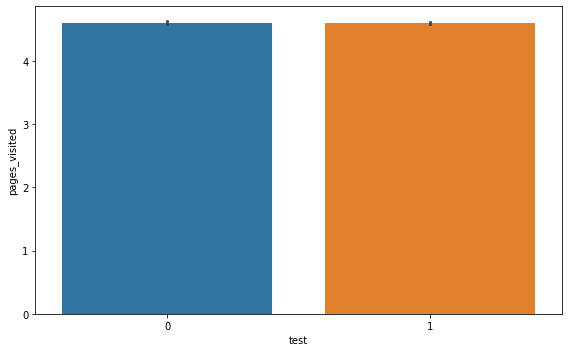

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='test', y='pages_visited', data=data, ax=ax)
plt.tight_layout()
plt.show()

I will conduct a ***Paired T-test*** at 0.05 significance level to conclude if the experiment was successful or not.

Control Group: People who were not exposed to the new feature in the newsfeed
Test Group: People who were exposed to the new feature in the newsfeed

Null Hypothesis: There is no difference in the number of pages visited by the two groups
Alternate Hypothesis: There is difference in the number of pages visited by the two groups

There are 49,846 users in the group group and 50,154 users in the test group. Variances are not equal.

In [19]:
# perform student's t-test
control_page = grouped_control['pages_visited'].values
experiment_page = grouped_test['pages_visited'].values

print(np.std(grouped_test['pages_visited'].values))
print(np.std(grouped_control['pages_visited'].values))

print(grouped_control.shape[0]),print(grouped_test.shape[0])

2.2046745991089884
2.7069106459565164
49846
50154


(None, None)

We can see p-value = 0.577 at 0.05 significance level.Hence, we do not have enough evidence to reject null hypothesis. The number of pages visited by both the groups is not significantly different.

In [20]:
print('T-test:\t', ttest_ind(a=control_page, b=experiment_page, equal_var=False))

T-test:	 Ttest_indResult(statistic=0.5571118435554797, pvalue=0.5774523171559118)


We can create t-test function that will be used later.

In [22]:
def run_ttest(df):
    vp_in_test = df.loc[data.test == 1, 'pages_visited']
    test_mean = vp_in_test.mean()
    
    vp_in_ctrl = df.loc[data.test == 0, 'pages_visited']
    ctrl_mean = vp_in_ctrl.mean()
    
    result = ttest_ind(vp_in_ctrl, vp_in_test, equal_var=False)
    conclusion = 'Significant' if result.pvalue < 0.05 else 'Not Significant'
    
    return pd.Series({'n_test':vp_in_test.shape[0],
                      'n_ctrl': vp_in_ctrl.shape[0],
                      'sum_pages_visited_test':vp_in_test.sum(),
                      'sum_pages_visited_ctrl':vp_in_ctrl.sum(),
                      'mean_test': test_mean,
                      'mean_ctrl': ctrl_mean,
                      'test-ctrl': test_mean - ctrl_mean,
                      'pvalue':result.pvalue,
                      'conclusion':conclusion})

We can see that the test has been running for a month and it's still not significant.

In [21]:
#Test has been running for a month
sorted(data.date.unique())

[numpy.datetime64('2015-08-01T00:00:00.000000000'),
 numpy.datetime64('2015-08-02T00:00:00.000000000'),
 numpy.datetime64('2015-08-03T00:00:00.000000000'),
 numpy.datetime64('2015-08-04T00:00:00.000000000'),
 numpy.datetime64('2015-08-05T00:00:00.000000000'),
 numpy.datetime64('2015-08-06T00:00:00.000000000'),
 numpy.datetime64('2015-08-07T00:00:00.000000000'),
 numpy.datetime64('2015-08-08T00:00:00.000000000'),
 numpy.datetime64('2015-08-09T00:00:00.000000000'),
 numpy.datetime64('2015-08-10T00:00:00.000000000'),
 numpy.datetime64('2015-08-11T00:00:00.000000000'),
 numpy.datetime64('2015-08-12T00:00:00.000000000'),
 numpy.datetime64('2015-08-13T00:00:00.000000000'),
 numpy.datetime64('2015-08-14T00:00:00.000000000'),
 numpy.datetime64('2015-08-15T00:00:00.000000000'),
 numpy.datetime64('2015-08-16T00:00:00.000000000'),
 numpy.datetime64('2015-08-17T00:00:00.000000000'),
 numpy.datetime64('2015-08-18T00:00:00.000000000'),
 numpy.datetime64('2015-08-19T00:00:00.000000000'),
 numpy.datet

# Question 2
Is the test performing similarly for all user segments or are there differences among different segments?

In [23]:
data.head()

,user_id,date,browser,test,pages_visited,signup_date
0,600597,2015-08-13,IE,0,2,2015-01-19
1,4410028,2015-08-26,Chrome,1,5,2015-05-11
2,6004777,2015-08-17,Chrome,0,8,2015-06-26
3,5990330,2015-08-27,Safari,0,8,2015-06-25
4,3622310,2015-08-07,Firefox,0,1,2015-04-17


### Test results by Browser

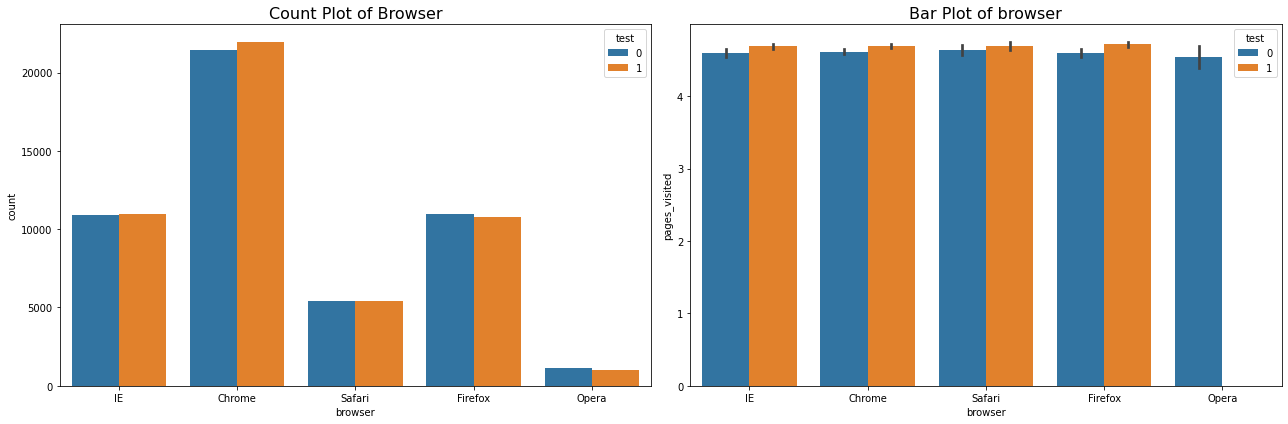

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x = 'browser',hue = 'test',data = data,ax = ax[0])
ax[0].set_title('Count Plot of Browser', fontsize=16)

sns.barplot(x = 'browser',y = 'pages_visited',hue = 'test',data = data,ax = ax[1])
ax[1].set_title('Bar Plot of browser', fontsize=16)
plt.tight_layout()
plt.show()  

We will apply t-test to the different browser groups i.e we will apply t-test to all chrome users and see if the test is significant or not.

In [25]:
data.groupby('browser').apply(run_ttest)

,n_test,n_ctrl,sum_pages_visited_test,sum_pages_visited_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
browser,,,,,,,,,
Chrome,21974,21453,103073,98970,4.690680,4.613341,0.077339,9.434084e-04,Significant
Firefox,10786,10972,50848,50473,4.714259,4.600164,0.114095,5.817199e-04,Significant
IE,10974,10906,51424,50151,4.685985,4.598478,0.087507,7.829509e-03,Significant
Opera,1018,1109,0,5042,0.000000,4.546438,-4.546438,2.252939e-321,Significant
Safari,5402,5406,25348,25074,4.692336,4.638180,0.054156,2.411738e-01,Not Significant


#### Results

We can see that,after applying this "Recommend Friend" feature
1. page_visited in Chrome, Firefox, IE have significantly increased.
2. page_visited in Opera has reduced to zero, maybe there is some bug in implementation on Opera, which stops users from visiting further pages.
3. page_visited in Safari has no significant improvement, maybe because the recommended friends isn't shown in a noticeable position.

### Test results by first time to tenured customers

In [28]:
data.head()

,user_id,date,browser,test,pages_visited,signup_date
0,600597,2015-08-13,IE,0,2,2015-01-19
1,4410028,2015-08-26,Chrome,1,5,2015-05-11
2,6004777,2015-08-17,Chrome,0,8,2015-06-26
3,5990330,2015-08-27,Safari,0,8,2015-06-25
4,3622310,2015-08-07,Firefox,0,1,2015-04-17


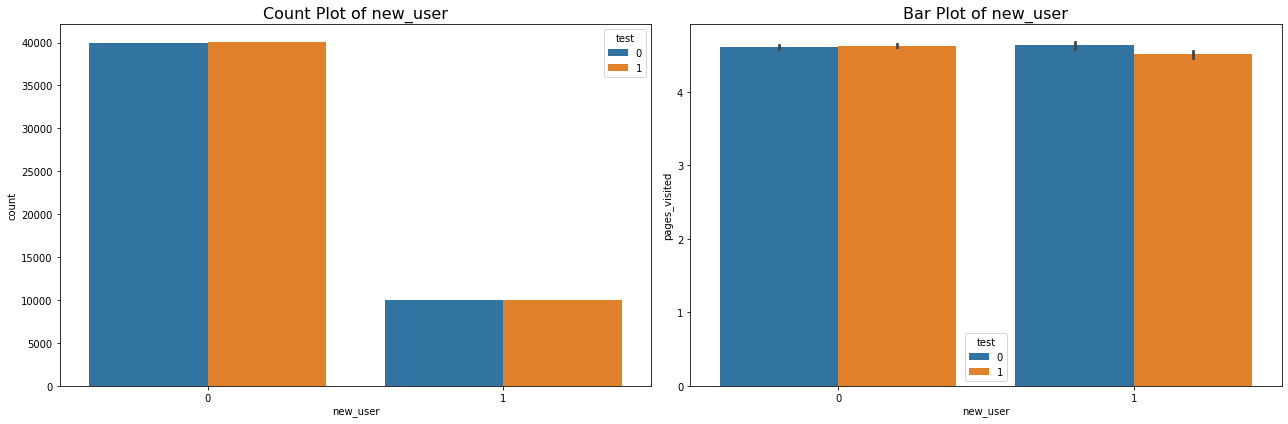

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x = 'new_user',hue = 'test',data = data,ax = ax[0])
ax[0].set_title('Count Plot of new_user', fontsize=16)

sns.barplot(x = 'new_user',y = 'pages_visited',hue = 'test',data = data,ax = ax[1])
ax[1].set_title('Bar Plot of new_user', fontsize=16)
plt.tight_layout()
plt.show() 

In [39]:
data.groupby('new_user').apply(run_ttest)

,n_test,n_ctrl,sum_pages_visited_test,sum_pages_visited_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
new_user,,,,,,,,,
0,40109,39890,185399,183625,4.622379,4.603284,0.019095,0.261837,Not Significant
1,10045,9956,45294,46085,4.509109,4.628867,-0.119758,0.001742,Significant


#### Results:

1. For old users, the new feature improve #page_visted, but the change isn't significant
2. for new users, this new feature significantly decreasse page_visited .
Since I already suspect there is some bug in Opera's implementation (which reduced the visited number to 0 after using this new feature), so I need to split the dataset further by browser.

# Browser and first time user 

In [40]:
res = data.groupby(['browser','new_user']).apply(run_ttest)
res

n_test  n_ctrl  sum_pages_visited_test  \
browser new_user                                           
Chrome  0          17525   17092                   82394   
        1           4449    4361                   20679   
Firefox 0           8657    8842                   41184   
        1           2129    2130                    9664   
IE      0           8779    8744                   41450   
        1           2195    2162                    9974   
Opera   0            833     883                       0   
        1            185     226                       0   
Safari  0           4315    4329                   20371   
        1           1087    1077                    4977   

                  sum_pages_visited_ctrl  mean_test  mean_ctrl  test-ctrl  \
browser new_user                                                            
Chrome  0                          78759   4.701512   4.607945   0.093567   
        1                          20211   4.648011   4.634488   0.013523   
Firefox 0                          40590   4.757306   4.590590   0.166716   
        1                           9883   4.539220   4.639906  -0.100686   
IE      0                          40140   4.721494   4.590576   0.130918   
        1                          10011   4.543964   4.630435  -0.086471   
Opera   0                           4057   0.000000   4.594564  -4.594564   
        1                            985   0.000000   4.358407  -4.358407   
Safari  0                          20079   4.720973   4.638254   0.082720   
        1                           4995   4.578657   4.637883  -0.059226   

                         pvalue       conclusion  
browser new_user                                  
Chrome  0          2.290889e-04      Significant  
        1          8.149175e-01  Not Significant  
Firefox 0          3.692901e-06      Significant  
        1          2.210706e-01  Not Significant  
IE      0          2.669847e-04      Significant  
        1          2.808421e-01  Not Significant  
Opera   0         7.204927e-255      Significant  
        1          1.222949e-68      Significant  
Safari  0          1.000829e-01  Not Significant  
        1          6.015241e-01  Not Significant

In [42]:
# first time users on each browser
res.xs(1,level=1)

#.xs is to retrieve a cross section of the pandas dataframe or series. First argument is for index which is 0 for rows or columns 1.

,n_test,n_ctrl,sum_pages_visited_test,sum_pages_visited_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
browser,,,,,,,,,
Chrome,4449,4361,20679,20211,4.648011,4.634488,0.013523,8.149175e-01,Not Significant
Firefox,2129,2130,9664,9883,4.539220,4.639906,-0.100686,2.210706e-01,Not Significant
IE,2195,2162,9974,10011,4.543964,4.630435,-0.086471,2.808421e-01,Not Significant
Opera,185,226,0,985,0.000000,4.358407,-4.358407,1.222949e-68,Significant
Safari,1087,1077,4977,4995,4.578657,4.637883,-0.059226,6.015241e-01,Not Significant


#### Results:

1. Besides Opera which may have a bug, all changes for new users are not significant, and there is even some drop in the number of pages visited after applying this new feature.

2. This could be because: the friend recommendation engine may be based on a user's previous social activity on the site. For new users, since they don't have any previous history for recommendation engine to use, the recommendation result is like a random guess, which cannot draw new user's interest. But the recommended friends may occupy some space on the page, so it may even decrease the pages visited for new users a little bit.

From this observation, I suspect the Recommedation Engine suffers ***the cold start*** problem.